In [23]:
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
)
from sklearn import metrics, model_selection
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
PATH_RNS = r"C:\Users\DY548\Documents\Python Scripts\trial\test data\PIT-RNS0427_PE20181120-1_EOF_SZ-NZ.EDF"

In [4]:
import mne

In [5]:
raw = mne.io.read_raw_edf(PATH_RNS)

Extracting EDF parameters from C:\Users\DY548\Documents\Python Scripts\trial\test data\PIT-RNS0427_PE20181120-1_EOF_SZ-NZ.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [6]:
type(raw)

mne.io.edf.edf.RawEDF

In [15]:
raw.plot()

Channels marked as bad:
none


In [10]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: channel1, channel2, channel3, channel4
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2019-03-20 09:49:01 UTC
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>

In [12]:
raw.get_data().shape

(4, 1335500)

In [13]:
raw.times

array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 5.341988e+03,
       5.341992e+03, 5.341996e+03])

In [14]:
1/(raw.times[1])

250.0

In [17]:
raw.annotations.onset

array([  64.696   ,  245.016   ,  425.336   ,  605.584   ,  785.904   ,
        966.224   , 1146.544   , 1186.759   , 1187.406404, 1326.864   ,
       1507.184   , 1687.504   , 1867.824   , 2048.144   , 2228.464   ,
       2408.784   , 2589.104   , 2769.424   , 2949.744   , 3130.064   ,
       3310.384   , 3490.704   , 3671.024   , 3851.344   , 4031.664   ,
       4211.984   , 4309.187192, 4392.304   , 4572.624   , 4752.944   ,
       4933.264   , 5113.584   , 5293.904   ])

In [19]:
raw.annotations.description

array(['eof', 'eof', 'eof', 'eof', 'eof', 'eof', 'eof', 'NZ5', 'sz_on',
       'eof', 'eof', 'eof', 'eof', 'eof', 'eof', 'eof', 'eof', 'eof',
       'eof', 'eof', 'eof', 'eof', 'eof', 'eof', 'eof', 'eof', 'sz_on',
       'eof', 'eof', 'eof', 'eof', 'eof', 'eof'], dtype='<U5')

In [20]:
raw.ch_names

['channel1', 'channel2', 'channel3', 'channel4']

In [24]:
nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=["ecog" for i in range(4)],
    reference=None,
    bads=None,
    new_names="default",
    used_types=("ecog",),
    target_keywords=None,

)

In [25]:
nm_channels

,name,rereference,used,target,type,status,new_name
0,channel1,None,1,0,ecog,good,channel1
1,channel2,None,1,0,ecog,good,channel2
2,channel3,None,1,0,ecog,good,channel3
3,channel4,None,1,0,ecog,good,channel4


In [26]:
stream = nm.Stream(
    settings=None,
    nm_channels=nm_channels,
    path_grids=None,
    verbose=True,
)

In [28]:
from pprint import pprint

In [31]:
pprint(stream.settings)

{'bandpass_filter_settings': {'bandpower_features': {'activity': True,
                                                     'complexity': False,
                                                     'mobility': False},
                              'kalman_filter': True,
                              'log_transform': True,
                              'segment_lengths_ms': {'HFA': 100,
                                                     'alpha': 500,
                                                     'high beta': 333,
                                                     'high gamma': 100,
                                                     'low beta': 333,
                                                     'low gamma': 100,
                                                     'theta': 1000}},
 'burst_settings': {'burst_features': {'amplitude': True,
                                       'burst_rate_per_s': True,
                                       'duration': True,
          

In [48]:
pprint(stream.settings["preprocessing"])

{'notch_filter': False,
 'preprecessing_order': [],
 'preprocessing_order': [],
 'raw_normalization': False,
 'raw_resampling': False,
 're_referencing': False}


In [47]:
stream.settings["preprocessing"]["notch_filter"] = False
stream.settings["preprocessing"]["preprocessing_order"] = []
stream.settings["preprocessing"]["raw_normalization"] = False
stream.settings["preprocessing"]["raw_resampling"] = False
stream.settings["preprocessing"]["re_referencing"] = False

In [34]:
stream.settings["features"]

{'raw_hjorth': True,
 'return_raw': True,
 'bandpass_filter': True,
 'stft': True,
 'fft': True,
 'sharpwave_analysis': True,
 'coherence': True,
 'fooof': True,
 'nolds': True,
 'bursts': True}

In [35]:
stream.settings["features"]["fft"] = True
stream.settings["features"]["raw_hjorth"] = False
stream.settings["features"]["return_raw"] = False
stream.settings["features"]["bandpass_filter"] = False
stream.settings["features"]["stft"] = False
stream.settings["features"]["sharpwave_analysis"] = False
stream.settings["features"]["coherence"] = False
stream.settings["features"]["fooof"] = False
stream.settings["features"]["nolds"] = False
stream.settings["features"]["bursts"] = False

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


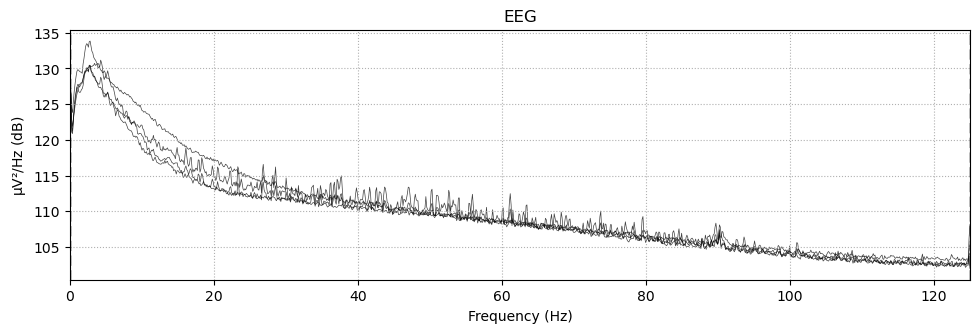

In [37]:
raw.plot_psd()
plt.show()

In [39]:
stream.settings["postprocessing"]["feature_normalization"] = False
stream.settings["postprocessing"]["project_cortex"] = False
stream.settings["postprocessing"]["project_subcortex"] = False

In [56]:
stream.settings["frequency_ranges_hz"] = \
{
"theta": [
            4,
            8
        ],
"alpha": [
            8,
            12
        ],
"low beta": [
            13,
            20
        ],
"high beta": [
            20,
            35
        ]
}
        

In [63]:
stream.settings["fft_settings"]["log_transform"] = False
stream.settings["fft_settings"]["kalman_filter"] = False

In [64]:
stream.settings["frequency_ranges_hz"]

{'theta': [4, 8],
 'alpha': [8, 12],
 'low beta': [13, 20],
 'high beta': [20, 35]}

In [65]:
stream.init_stream(
    sfreq=250,
    line_noise=60,
    coord_list=[],
    coord_names=[],
)


No Error occurred when testing the settings.


In [66]:
os.getcwd()

'c:\\Users\\DY548\\Documents\\GitHub\\py_neuromodulation\\examples'

In [68]:
stream.run(
    data=raw.get_data(),
    out_path_root=os.getcwd(),
    folder_name="TestRNS",
)

ValueError: If data is passed as an array, the first dimension must match the number of channel names in `nm_channels`. Got: Data columns: 1335500, nm_channels.name: 4.